In [1]:
# Import data and libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import matplotlib
import matplotlib.pylab as pylab
#from mpl_toolkits.basemap import Basemap
pylab.rcParams['figure.figsize'] = 16, 12
pd.options.display.mpl_style = 'default'
get_ipython().magic(u'matplotlib inline')
import ibuttonplots
import importibuttondata
%matplotlib inline
from matplotlib.path import Path


import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapQuestOSM

/Users/annascott2/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.



In [2]:
meta = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))

In [7]:
# Import data and libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import matplotlib
import matplotlib.pylab as pylab
#from mpl_toolkits.basemap import Basemap
pylab.rcParams['figure.figsize'] = 16, 12
#pd.options.display.mpl_style = 'default'
plt.style.use('ggplot')
get_ipython().magic(u'matplotlib inline')
import ibuttonplots
import importibuttondata
%matplotlib inline
from matplotlib.path import Path
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
#from cartopy.io.img_tiles import MapQuestOSM

pylab.rcParams['font.family'] = 'serif' 
pylab.rcParams['font.size'] = 14
pylab.rcParams['axes.titlesize'] = 22

files = glob.glob('./data/*[tT].csv')
#meta0 = pd.DataFrame(pd.read_csv('./data/bmoremetadata.csv', sep = ','))
meta0 = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))
tempDF0, anomalyDF0, meta0 = importibuttondata.importdata(files, meta0)

#files = glob.glob('./data/*[tT].csv')
files = glob.glob('./data/falldownload/*[tT].csv')
meta1 = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))
#meta0 = pd.DataFrame(pd.read_csv('./data/bmoremetadata.csv', sep = ','))
tempDF1, anomalyDF1, meta1 = importibuttondata.importdata(files, meta1)

frames = [tempDF0, tempDF1]
tempDF = pd.concat(frames)
anomalyDF = pd.concat([anomalyDF0, anomalyDF1])
meta = pd.concat([meta0, meta1.loc()[np.setdiff1d(meta1.sensornumber, meta0.sensornumber)]])

importibuttondata.py:28: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  meta = meta.sort(axis=0) # sort the data in order of the sensor number
importibuttondata.py:59: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  meta = meta.loc[np.intersect1d(tempDF.columns.values, meta.sensornumber.values)]


TypeError: f() got an unexpected keyword argument 'axis'

In [3]:
#def importdata(files,meta) :
#       meta = pd.DataFrame(pd.read_csv(metafile, sep = ','))
files = glob.glob('./data/falldownload/*[tT].csv')
meta = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))

meta = meta.set_index(meta['sensornumber']) # set the row names for metadata to be the sensor number
date_spec = {'Date': [ 0]}

for index in meta.index: # loop over the sensor numbers in metadata and check if they are numbers
    try :
        str.isdigit(index)
        if str.isdigit(index)== 0:
            meta = meta.drop(meta.loc[index]) # delete the rows without sensor numbers
    except TypeError:
        pass
meta = meta.sort(axis=0) # sort the data in order of the sensor number
meta = meta.set_index(meta['sensornumber'].astype(int))

# read in all the csv files into a Panda's dataframe, skipping the headers of the csv files
frames = []
sensornumbers = []
for file in files:
    try : 
        colnumber = int(os.path.splitext(os.path.basename(file))[0][0:-1])
        frame = pd.read_csv(file, sep = ',',
                skiprows = 19, 
                parse_dates = date_spec,
                keep_date_col=True)
        frame = frame.set_index('Date').rename(columns = {'Value': colnumber})

        try: 
                startdate = pd.to_datetime(meta['time'][colnumber]) #when the sensor was installed according to metadata
                ind = np.argmin([abs(frame.index -startdate)]) # Find the closest recording time to when put out
                frames.append(frame[ind+1:]) # only save the data from the hour after the sensor was installed
        except KeyError:  
                frames.append(frame)
        #ind = np.argmin([abs(frame.index -startdate)]) # Find the closest recording time to when put out
        #frames.append(frame[ind+1:]) # only save the data from the hour after the sensor was installed
        #frames.append(frame)
        #frames.append(pd.read_csv(file, sep = ',', skiprows = 19, parse_dates = date_spec, keep_date_col=True).set_index('Date').rename(columns = {'Value': int(os.path.splitext(os.path.basename(file))[0][0:-1])}))

    except ValueError:
        print "oops... something went wrong"

tempDF = pd.concat(frames, axis =1).resample('H')
#tempDF = pd.concat(frames, axis =1).resample('H').dropna()
meta = meta.loc[np.intersect1d(tempDF.columns.values, meta.sensornumber.values)]

#clim = tempDF.mean().mean(axis=1) # the temperature 'climatology'
#anomaly = tempDF - np.tile(clim[:,np.newaxis], (1, tempDF.shape[1])) # the anomaly data
#anomalyDF = pd.DataFrame(anomaly, tempDF.index, tempDF.columns).sort(axis=1)

meta = meta.loc[np.intersect1d(tempDF.columns.values, meta.sensornumber.values)]

# categorize sensors
ebaltsensorsi = np.where(meta['location:Longitude']>= -76.6125831)#-76.61)# -76.6072591 )
parksi = np.where((meta['landcoverclass'] != 'impervious') & (meta['location:Longitude']>= -76.6125831)) # -76.61) )

parksensors = meta.sensornumber.iloc[parksi]
ebaltsensors = meta.sensornumber.iloc[ebaltsensorsi]
nonparks = np.setdiff1d(ebaltsensors, parksensors)

selected = ebaltsensors

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(....) is deprecated, use sort_index(.....)
/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


In [16]:
#tempDF.mean().mean().to_csv('meantemp.csv')
mean_temp = tempDF.mean().mean()
#pd.read_csv('meantemp.csv')

In [4]:
def mapmean(tempDF, meta, name = '', option = 0):
    import cartopy.crs as ccrs
    from cartopy.io.img_tiles import MapQuestOSM
    #fig  = plt.figure(figsize=(30, 30))
    x = meta['location:Longitude'].values
    y = meta['location:Latitude'].values
    c = tempDF[meta.sensornumber].mean()
    marker_size = 100
    fig = plt.figure(figsize=[15,15])
    imagery = MapQuestOSM()
    ax = plt.axes(projection=imagery.crs)
    
    ax.set_extent(( meta['location:Longitude'].min()-.005, 
                   meta['location:Longitude'].max()+.005 , 
                   meta['location:Latitude'].min()-.005,
                   meta['location:Latitude'].max()+.005))
    ax.add_image(imagery, 14)

    cmap = matplotlib.cm.OrRd
    bounds = np.linspace(round((c.mean()-3)),round((c.mean()+3)),13)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    plotHandle = ax.scatter(x,y,c = c, s = 350, transform=ccrs.Geodetic(), 
                 cmap = cmap,
                 norm = norm)
    if option ==0 : 
        cbar1 = plt.colorbar(plotHandle, label = 'Temperature in $^\circ $C')
    else : 
        cbar1 = plt.colorbar(plotHandle, label = option)
    
    lon = x[np.nanargmax(c)]
    lat = y[np.nanargmax(c)]
    at_x, at_y = ax.projection.transform_point(lon, lat,
                                               src_crs=ccrs.Geodetic())
    plt.annotate(
        '%2.1f'%np.nanmax(c.values), xy=(at_x, at_y), #xytext=(30, 20), textcoords='offset points',
        color='black', backgroundcolor='none', size=22,
        )

    lon = x[np.nanargmin(c)]
    lat = y[np.nanargmin(c)]
    at_x, at_y = ax.projection.transform_point(lon, lat,
                                               src_crs=ccrs.Geodetic())
    plt.annotate(
        '%2.1f'%np.nanmin(c.values), xy=(at_x, at_y), #xytext=(30, 20), textcoords='offset points',
        color='black', size = 22, backgroundcolor='none')

    plt.annotate(
        '$\mu = $ %2.1f'%np.nanmean(c.values), (0.01,0.01), xycoords ='axes fraction', #xytext=(30, 20), textcoords='offset points',
        color='black', size = 22, backgroundcolor='none')
    
    plt.title('Mean Temperature %s'%name)
    filename = './plots/meantempmap%s.eps'%name
    plt.savefig(filename, format = 'eps', dpi = 600)

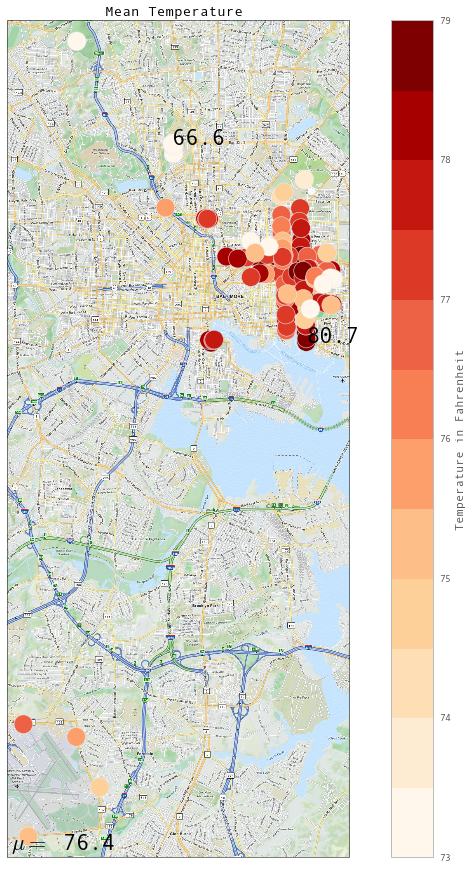

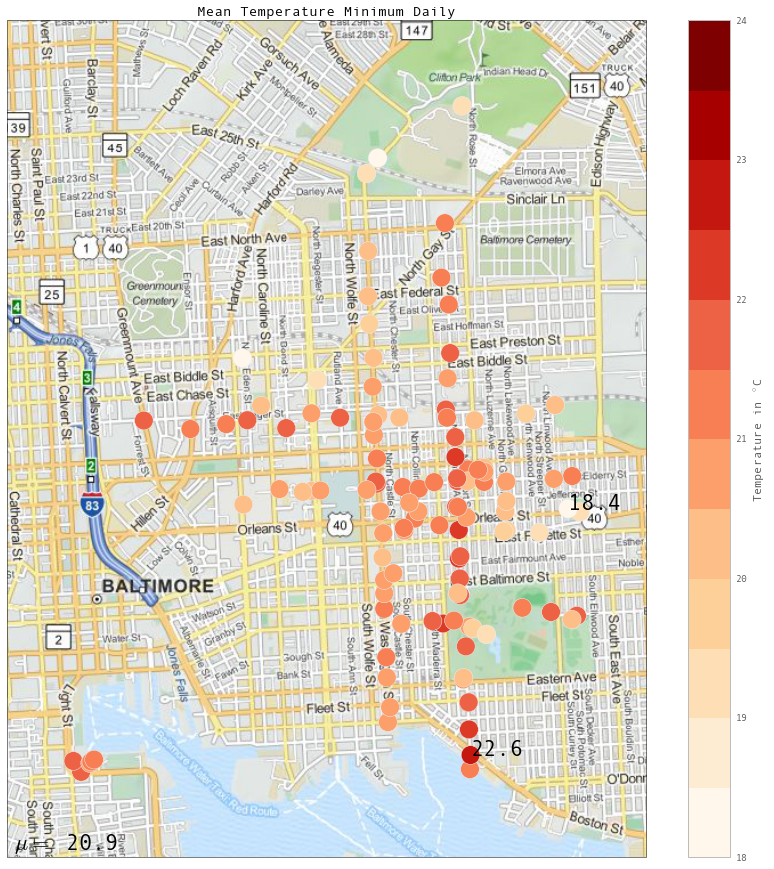

In [7]:
mapmean(tempDF*9/5+32., meta, name = '', option = 'Temperature in Fahrenheit')
mapmean(tempDF.resample('D', how = 'min')[selected], 
                     meta.loc[selected], name = 'Minimum Daily')

In [7]:
# categorize sensors
ebaltsensorsi = np.where(meta['location:Longitude']>= -76.6125831)#-76.61)# -76.6072591 )
parksi = np.where((meta['landcoverclass'] != 'impervious') & (meta['location:Longitude']>= -76.6125831)) # -76.61) )

parksensors = meta.sensornumber.iloc[parksi]
ebaltsensors = meta.sensornumber.iloc[ebaltsensorsi]
nonparks = np.setdiff1d(ebaltsensors, parksensors)

selected = ebaltsensors

In [42]:
### gis functions
from osgeo import ogr, osr
import os
from shapely.geometry import Point
import shapely.geometry
import shapely.wkt
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import gdal

# reproject 'Parks_Dissolved.shp'
def mapmean(tempDF, meta, name = '', option = 0):
    import cartopy.crs as ccrs
    from cartopy.io.img_tiles import MapQuestOSM
    #fig  = plt.figure(figsize=(30, 30))
    x = meta['location:Longitude'].values
    y = meta['location:Latitude'].values
    c = tempDF[meta.sensornumber].mean()
    marker_size = 100
    fig = plt.figure(figsize=[15,15])
    imagery = MapQuestOSM()
    ax = plt.axes(projection=imagery.crs)
    
    ax.set_extent(( meta['location:Longitude'].min()-.005, 
                   meta['location:Longitude'].max()+.005 , 
                   meta['location:Latitude'].min()-.005,
                   meta['location:Latitude'].max()+.005))
    ax.add_image(imagery, 14)

    cmap = matplotlib.cm.OrRd
    bounds = np.linspace(round((c.mean()-3)),round((c.mean()+3)),13)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    plotHandle = ax.scatter(x,y,c = c, s = 350, transform=ccrs.Geodetic(), 
                 cmap = cmap,
                 norm = norm)
    if option ==0 : 
        cbar1 = plt.colorbar(plotHandle, label = 'Temperature in $^\circ $C')
    else : 
        cbar1 = plt.colorbar(plotHandle, label = option)
    
    lon = x[np.nanargmax(c)]
    lat = y[np.nanargmax(c)]
    at_x, at_y = ax.projection.transform_point(lon, lat,
                                               src_crs=ccrs.Geodetic())
    plt.annotate(
        '%2.1f'%np.nanmax(c.values), xy=(at_x, at_y), #xytext=(30, 20), textcoords='offset points',
        color='black', backgroundcolor='none', size=22,
        )

    lon = x[np.nanargmin(c)]
    lat = y[np.nanargmin(c)]
    at_x, at_y = ax.projection.transform_point(lon, lat,
                                               src_crs=ccrs.Geodetic())
    plt.annotate(
        '%2.1f'%np.nanmin(c.values), xy=(at_x, at_y), #xytext=(30, 20), textcoords='offset points',
        color='black', size = 22, backgroundcolor='none')

    plt.annotate(
        '$\mu = $ %2.1f'%np.nanmean(c.values), (0.01,0.01), xycoords ='axes fraction', #xytext=(30, 20), textcoords='offset points',
        color='black', size = 22, backgroundcolor='none')
    
    plt.title('Mean Temperature %s'%name)
    filename = './plots/meantempmap%s.eps'%name
    plt.savefig(filename, format = 'eps', dpi = 600)
    
def reproject_shapefile(fname,outfilename,outProjection = "WGS84"): 
    #fname = 'Parks_Dissolved.shp'
    driver = ogr.GetDriverByName('ESRI Shapefile')

    # input SpatialReference
    datasource = ogr.GetDriverByName('ESRI Shapefile').Open(fname)
    inlayer  = datasource.GetLayer()
    inSpatialRef = inlayer.GetSpatialRef()

    # output SpatialReference
    outSpatialRef = osr.SpatialReference()
    outSpatialRef.SetWellKnownGeogCS(outProjection)

    # create the CoordinateTransformation
    coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

    # get the input layer
    inDataSet = driver.Open(fname)
    inLayer = inDataSet.GetLayer()

    # create the output layer
    outputShapefile = outfilename + '.shp'
    if os.path.exists(outputShapefile):
        driver.DeleteDataSource(outputShapefile)
    outDataSet = driver.CreateDataSource(outputShapefile)
    outLayer = outDataSet.CreateLayer("basemap_wgs84", geom_type=ogr.wkbMultiPolygon)

    # add fields
    inLayerDefn = inLayer.GetLayerDefn()
    for i in range(0, inLayerDefn.GetFieldCount()):
        fieldDefn = inLayerDefn.GetFieldDefn(i)
        outLayer.CreateField(fieldDefn)

    # get the output layer's feature definition
    outLayerDefn = outLayer.GetLayerDefn()

    # loop through the input features
    inFeature = inLayer.GetNextFeature()
    while inFeature:
        # get the input geometry
        geom = inFeature.GetGeometryRef()
        # reproject the geometry
        geom.Transform(coordTrans)
        # create a new feature
        outFeature = ogr.Feature(outLayerDefn)
        # set the geometry and attribute
        outFeature.SetGeometry(geom)
        for i in range(0, outLayerDefn.GetFieldCount()):
            outFeature.SetField(outLayerDefn.GetFieldDefn(i).GetNameRef(), inFeature.GetField(i))
        # add the feature to the shapefile
        outLayer.CreateFeature(outFeature)
        # destroy the features and get the next input feature
        outFeature.Destroy()
        inFeature.Destroy()
        inFeature = inLayer.GetNextFeature()
        
    spatialRef = osr.SpatialReference()
    spatialRef.SetWellKnownGeogCS(outProjection)
    spatialRef.MorphToESRI()
    file = open(outfilename+'.prj', 'w')
    file.write(spatialRef.ExportToWkt())
    file.close()

    # close the shapefiles
    inDataSet.Destroy()
    outDataSet.Destroy

def extract_raster_values(X,Y, rasterfile, transform = 'true'): 
    # Note: this isn't written to not transform
    # 
    # Transform lat/lon values to the raster projection 
    if transform == 'true':
        sourceEPSG = 4326
        targetEPSG = 6347
        source = osr.SpatialReference()
        source.ImportFromEPSG(sourceEPSG)
        target = osr.SpatialReference()
        #target =layer.GetGeoTransform()
        target.ImportFromEPSG(targetEPSG)

        transform = osr.CoordinateTransformation(source, target)
    else : 
        transform = '' # need to figure this out....

    # Read in DEM
    file = rasterfile #'exportImage'
    layer = gdal.Open(file)
    gt =layer.GetGeoTransform()
    bands = layer.RasterCount

    #point = ogr.CreateGeometryFromWkt("POINT (%s %s)"%(x,y))
    #Y = meta['location:Latitude']
    #X = meta['location:Longitude']
    elevation = np.zeros(X.shape[0])

    i = 0 
    for x,y in zip(X,Y): 
        if ~np.isnan(x) & ~np.isnan(y): 
            point = ogr.Geometry(ogr.wkbPoint)
            point.AddPoint(x,y)
            point.Transform(transform)
            #print point.ExportToWkt()

            x = point.GetPoints()[0][0]
            y = point.GetPoints()[0][1]

            rasterx = int((x - gt[0]) / gt[1])
            rastery = int((y - gt[3]) / gt[5])

            elevation[i] = layer.GetRasterBand(1).ReadAsArray(rasterx,rastery, 1, 1) 
            #print layer.GetRasterBand(1).ReadAsArray(rasterx,rastery, 1, 1) 
        else:
            print 'missing data at ', i
        i = i+1
    return elevation

def compute_distance_to_feature(X,Y,feature_file, feature_name = 'none', projection = ''):
# compute distance from an array of lons/lats to a feature
# if multiple features in shapefile, specify feature_name
    
    #feature_file = 'data/Parks_Dissolved_reproj.shp'
    # Read in shapefile for the feature
    shapefile = ogr.Open(feature_file)
    layer = shapefile.GetLayer(0)
    
    # Select the correct feature
    if feature_name == 'none': 
        feature = layer.GetFeature(0)
        geometry = feature.GetGeometryRef()
        shape = shapely.wkt.loads(geometry.ExportToWkt())
    else: 
        for i in range(layer.GetFeatureCount()):
            feature = layer.GetFeature(i)
            name = feature.GetField('name')
            if name == feature_name : 
                geometry = feature.GetGeometryRef()
                shape = shapely.wkt.loads(geometry.ExportToWkt())
    
    ### Transform
    # reproject lat/lon values to the raster
    inSpatialRef = osr.SpatialReference()
    inSpatialRef.ImportFromEPSG(4326) # lat lon

    outSpatialRef = osr.SpatialReference()
    outSpatialRef = layer.GetSpatialRef()

    # create the CoordinateTransformation
    coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
    i = 0
    distance_to_park = np.zeros(X.shape)
    for (x,y) in zip(X,Y): 
        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(x,y)
        point.Transform(coordTrans)
        distance_to_park[i] = Point(point.GetPoints()[0]).distance(shape)
        i = i+1
    # transform to meters
    distance_to_park = distance_to_park*2*np.pi/360*6371000.    
    return distance_to_park

def map_data(data, lat,lon, shapefiles = 'none'): 
    # gis_layers a list of filenames
    
    # first, check that lat, lon, and data all same size
    if lat.shape != lon.shape : 
        print 'Lat and lon data shape do not match' 
    elif lat.shape != data.shape : 
        print 'Lat/lon & data shape do not match'
        
    # set up figures and axes    
    plt.figure(figsize=[15,15])
    if shapefiles == 'none': 
        imagery = MapQuestOSM()
        ax = plt.axes(projection=imagery.crs)
        ax.add_image(imagery, 14)
    else: 
        ax = plt.axes(projection=ccrs.PlateCarree()) # note to self:put in UTM 18/19

    ax.set_extent((lon.min()-.05, 
               lon.max()+.05 , 
               lat.min(),
               lat.max()+.05))
    
    # if there are shapefiles, read in and display
    if shapefiles != 'none' : 
        for file in shapefiles: 
            shape_feature = ShapelyFeature(Reader(file).geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='black')
            ax.add_feature(shape_feature)
    
    # define colormap
    cmap = matplotlib.cm.OrRd
    bounds = np.linspace(round((data.mean()-2*data.std())),round((data.mean()+2*data.std())),13)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    # plot
    plotHandle = ax.scatter(lon,lat,c= data, s = 150, transform=ccrs.Geodetic(), 
                 cmap = cmap,
                 norm = norm)
    
    return ax, plotHandle

def band10_toLST(band10): 
    # convert landsat band 10 to land surface temperature
    # convert from digital numbers to (spectral) radiance
    m_l = 3.3420E-04 # gain
    a_l = 0.10000 # bias
    radiance = m_l * band10 + a_l
    # convert from radiance to temperature by inverting the planck function
    k1 = 774.8853 
    k2 = 1321.0789
    temp = k2/ (np.log(k1/radiance +1)) -273.15
    temp[temp < -100] = 'nan'
    
    return temp

def albedo(B1,B2,B3,B4,B5) : 
# ((0.356*B1) + (0.130*B2) + (0.373*B3) + (0.085*B4) + (0.072*B5) -0.018) / 1.016
    return ((0.356*B1) + (0.130*B2) + (0.373*B3) + (0.085*B4) + (0.072*B5) -0.018)/1.016

In [53]:
reproject_shapefile('data/Parks_Dissolved.shp',outfilename='data/Parks_Dissolved_reproj')

In [55]:
B

array([[ 12596.,  11411.,  11871.,  11928.,  11772.,  11408.,  11679.,
         11088.,  11646.,  12202.,  11895.,  12567.,  12408.,  11705.,
         12624.,  13075.,  12119.,  12766.,  12584.,  13115.,  11700.,
         11858.,  11086.,  12589.,  12014.,  10697.,  12038.,  12208.,
         12738.,  12734.,  11994.,  13806.,  11833.,  11335.,  12599.,
         12320.,  11559.,  12208.,  12315.,  14104.,  12344.,  12492.,
         12434.,  11427.,  12530.,  12479.,  12563.,  14884.,  12209.,
         12523.,  12261.,  11852.,  12775.,  12350.,  12974.,  12010.,
         12157.,  10904.,  13206.,  12073.,  12673.,  14666.,  12227.,
         12861.,  12910.,  12422.,  12793.,  12816.,  11734.,  12523.,
         13272.,  12122.,  12264.,  12271.,  11715.,  12369.,  13755.,
         11852.,  14036.,  13712.,  12046.,  11620.,  12376.,  12280.,
         12607.,  12556.,  12415.,  11045.,  12572.,  12386.,  13344.,
         12385.,  11930.,  12419.,  13205.,  12164.,  12589.,  12492.,
      

In [56]:
lon = meta.drop(64, axis=0)['location:Longitude'][selected].values
lat = meta.drop(64, axis=0)['location:Latitude'][selected].values

path = '../satellite/data/BaltimoreLandsatSummer2015/L8 OLI_TIRS/LC80150332015229LGN00/'
B = np.zeros((5,lon.shape[0]))
for i in (1,2,3,4,5): 
    file = path+ 'LC80150332015229LGN00_B'+'%s'%i +'.TIF'
    B[i-1, :] = extract_raster_values(lon,lat,file)
# LC80150332015229LGN00_B1.TIF
#B1 = extract_raster_values(lon,lat,)
alb = albedo(B[0,:], B[1,:], B[2,:], B[3,:], B[4,:], )

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x10d27eb10>,
 <matplotlib.collections.PathCollection at 0x10d98ad50>)

/Users/ascott47/anaconda/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


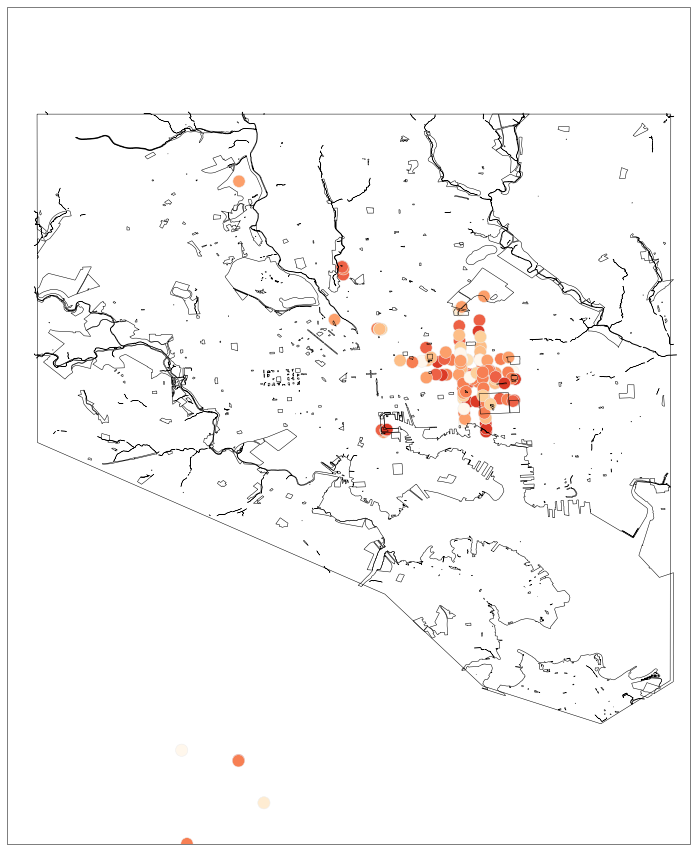

In [13]:
data = tempDF.drop([49,64], axis=1).mean()
lon = meta.drop(64, axis=0)['location:Longitude'].values
lat = meta.drop(64, axis=0)['location:Latitude'].values

shapefiles = ('data/Baltimore City Line/geo_export_622ca14a-cf38-48b1-b961-89de6f7067b9.shp', 
             'data/Parks_Dissolved_reproj.shp', 
              'data/Water-2/geo_export_a5e512a2-2fa2-47e8-ac32-78f85e798a3c.shp'
             )
map_data(data, lat,lon, shapefiles = shapefiles)

In [44]:
# compute possible co-variates for regression with mean temeprature
lon = meta.drop(64, axis=0)['location:Longitude'][selected].values
lat = meta.drop(64, axis=0)['location:Latitude'][selected].values

feature_file = 'data/Parks_Dissolved_reproj.shp'
distance_to_park = compute_distance_to_feature(lon,lat,feature_file, feature_name = 'none')

feature_file = 'data/Water-2/geo_export_a5e512a2-2fa2-47e8-ac32-78f85e798a3c.shp'
distance_to_water = compute_distance_to_feature(lon,lat,feature_file, feature_name = 'Inner Harbor')

rasterfile = 'data/BaltimoreDEM'
elevation = extract_raster_values(lon,lat, rasterfile, transform = 'true')

rasterfile ='../satellite/LC80150332015229LGN00_B10.TIF' 
band10 = extract_raster_values(lon,lat, rasterfile, transform = 'true')
LST = band10_toLST(band10)

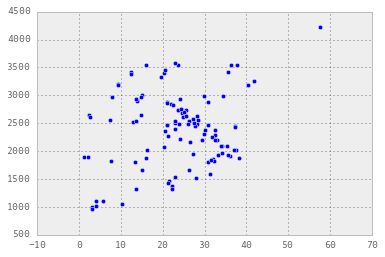

In [22]:
rasterfile = 'data/BaltimoreDEM'
elevation = extract_raster_values(lon,lat, rasterfile, transform = 'true')
plt.scatter(elevation, distance_to_water)

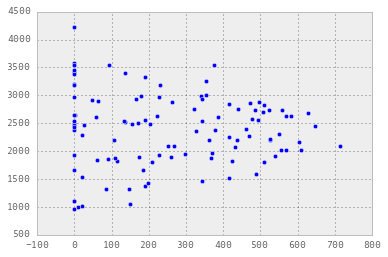

In [11]:
plt.scatter(distance_to_park, distance_to_water)

In [17]:
import pandas as pd
import statsmodels.formula.api as sm
temp_data =tempDF.drop([49,64], axis=1).mean()[selected]#tempDF.drop([49,64], axis=1).mean()

df = pd.DataFrame({"A": temp_data, "B": distance_to_park, "C": distance_to_water, "D": LST})
result = sm.ols(formula="A ~ B+ C+ D", data=df).fit()
print result.params
print result.summary()

Intercept    23.109823
B             0.000826
C            -0.000410
D             0.084705
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      A   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     6.494
Date:                Wed, 20 Apr 2016   Prob (F-statistic):           0.000436
Time:                        11:18:15   Log-Likelihood:                -149.19
No. Observations:                 114   AIC:                             306.4
Df Residuals:                     110   BIC:                             317.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  app.launch_new_instance()


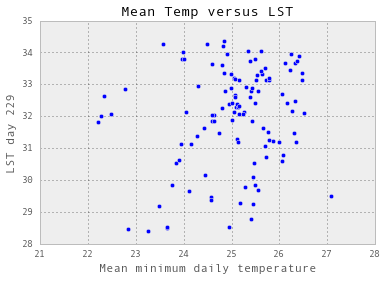

In [18]:
plt.scatter(temp_data, LST)
plt.xlabel('Mean minimum daily temperature')
plt.ylabel('LST day 229')
plt.title('Mean Temp versus LST')

In [ ]:
import pandas as pd
import statsmodels.formula.api as sm
lst = np.zeros(10)
temp = 20*np.ones(10)
df = pd.DataFrame({"A": temp, "B": elevation, "C": lst})
result = sm.ols(formula="A ~ B + C", data=df).fit()
print result.params
print result.summary()

In [20]:
sm.ols?

1) Table to make : 
$$ T_{air}, LST, elevation, dist_water, \%tree_cover, albedo $$

2) regression: $$ T_{air} = f(LST, elevation, dist_water, tree_cover, as.factor(park)) $$
where as.factor(park) describes park as a categorical variable 

3) regression with time $ var(T) = f(RH, insol, U, precip) $

In [12]:
temp_data =tempDF.drop([49,64], axis=1).mean()[selected]#tempDF.drop([49,64], axis=1).mean()
df = pd.DataFrame({"AirTemp": temp_data, "Elevation": elevation, "LST": LST, "water_distance": distance_to_water, "park_distance": distance_to_park})
df.corr()

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  if __name__ == '__main__':


,AirTemp,Elevation,LST,park_distance,water_distance
AirTemp,1.000000,-0.133329,0.205734,0.271149,-0.271071
Elevation,-0.133329,1.000000,0.010070,0.239658,0.218696
LST,0.205734,0.010070,1.000000,0.573323,0.111266
park_distance,0.271149,0.239658,0.573323,1.000000,-0.059958
water_distance,-0.271071,0.218696,0.111266,-0.059958,1.000000


In [67]:
#import rpy2
#import statsmodels.formula.api as sm
y = np.concatenate((np.arange(.5,5.5, .5), np.arange(10.5, 15.5, .5)))
x1 = np.arange(1,21)
x2 = np.concatenate((np.zeros(10), np.ones(10)), axis=0)
df = pd.DataFrame({"Response":y, "ContinuousPredict":x1, "CategoricalPredict":x2})
result = sm.ols(formula="Response~ ContinuousPredict + C(CategoricalPredict)", data=df).fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.034e+30
Date:                Thu, 21 Apr 2016   Prob (F-statistic):          5.98e-248
Time:                        14:54:00   Log-Likelihood:                 608.35
No. Observations:                  20   AIC:                            -1211.
Df Residuals:                      17   BIC:                            -1208.
Df Model:                           2                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                     1.976e-14   8.61e-15      2.295      0.035      1.59e-15  3.79e-1

In [68]:
result = sm.ols(formula="Response~ ContinuousPredict + CategoricalPredict", data=df).fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.451e+32
Date:                Thu, 21 Apr 2016   Prob (F-statistic):          3.35e-266
Time:                        15:00:02   Log-Likelihood:                 657.79
No. Observations:                  20   AIC:                            -1310.
Df Residuals:                      17   BIC:                            -1307.
Df Model:                           2                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            2.22e-16   7.27e-16      0.305      0.764     -1.31e-15  1.76e-15
ContinuousPredict      0.500